In [1]:
import os        
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,Input,Dense,Activation,BatchNormalization,Dropout,Conv2D,MaxPool2D
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

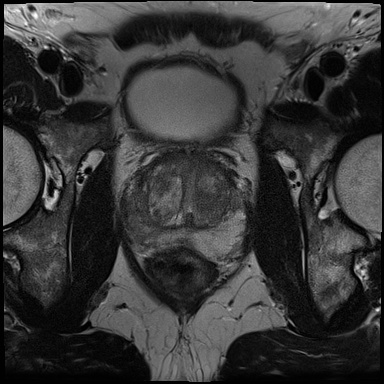

In [ ]:
from google.colab.patches import cv2_imshow
image=cv2.imread("/content/drive/MyDrive/Prostate Cancer/train/notsignificant/nosignificativo0-0009.jpg")
cv2_imshow(image)

In [ ]:
heights=[]
widths=[]
for file in os.listdir("/content/drive/MyDrive/Prostate Cancer/train/notsignificant"):
  image=cv2.imread("/content/drive/MyDrive/Prostate Cancer/train/notsignificant/"+file)
  heights.append(image.shape[0])
  widths.append(image.shape[1])

In [ ]:
heights[0]

384

(array([  0.,   0.,   0.,   0.,   0., 536.,   0.,   0.,   0.,   0.]),
 array([383.5, 383.6, 383.7, 383.8, 383.9, 384. , 384.1, 384.2, 384.3,
        384.4, 384.5]),
 <a list of 10 Patch objects>)

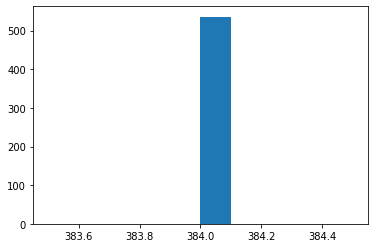

In [ ]:
import matplotlib.pyplot as plt
plt.hist(widths)

(array([  0.,   0.,   0.,   0.,   0., 536.,   0.,   0.,   0.,   0.]),
 array([383.5, 383.6, 383.7, 383.8, 383.9, 384. , 384.1, 384.2, 384.3,
        384.4, 384.5]),
 <a list of 10 Patch objects>)

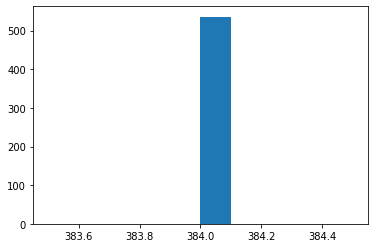

In [ ]:
plt.hist(heights)

In [ ]:
#merge the data
!rm -r data
!mkdir data
!mkdir data/nonsignificant
!mkdir data/significant


rm: cannot remove 'data': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/Prostate\ Cancer/test/significant/* data/significant
!cp /content/drive/MyDrive/Prostate\ Cancer/train/significant/* data/significant
!cp /content/drive/MyDrive/Prostate\ Cancer/validation/significant/* data/significant

In [ ]:
!cp /content/drive/MyDrive/Prostate\ Cancer/test/nonsignificant/* data/nonsignificant
!cp /content/drive/MyDrive/Prostate\ Cancer/train/notsignificant/* data/nonsignificant
!cp /content/drive/MyDrive/Prostate\ Cancer/validation/notsignificant/* data/nonsignificant

In [ ]:
!mkdir train
!mkdir train/nonsignificant
!mkdir train/significant


!mkdir test
!mkdir test/nonsignificant
!mkdir test/significant


!mkdir val
!mkdir val/nonsignificant
!mkdir val/significant

In [ ]:
from scipy.sparse.construct import rand
p=0.8
import random
for f in os.listdir("/content/data/nonsignificant"):
  v=random.random()
  if v<0.8:
    !cp /content/data/nonsignificant/$f /content/train/nonsignificant/$f
  elif v<0.9:
     !cp /content/data/nonsignificant/$f /content/val/nonsignificant/$f
  else:
    !cp /content/data/nonsignificant/$f /content/test/nonsignificant/$f

for f in os.listdir("/content/data/significant"):
  v=random.random()
  if v<0.8:
    !cp /content/data/significant/$f /content/train/significant/$f
  elif v<0.9:
     !cp /content/data/significant/$f /content/val/significant/$f
  else:
    !cp /content/data/significant/$f /content/test/significant/$f

In [ ]:
print(len(os.listdir("/content/train/nonsignificant")))
print(len(os.listdir("/content/train/significant")))
print(len(os.listdir("/content/val/nonsignificant")))
print(len(os.listdir("/content/val/significant")))
print(len(os.listdir("/content/test/nonsignificant")))
print(len(os.listdir("/content/test/significant")))

599
609
81
85
80
70


In [ ]:
train_datagen = ImageDataGenerator(
    
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,


    vertical_flip=True,



    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

test_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
val_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
shape=224

In [ ]:
train=train_datagen.flow_from_directory("/content/train",class_mode="binary",target_size=(shape,shape),batch_size=16)
val=val_datagen.flow_from_directory("/content/val",class_mode="binary",target_size=(shape,shape),batch_size=16)
test=test_datagen.flow_from_directory("/content/test",class_mode="binary",target_size=(shape,shape),batch_size=16)

Found 1208 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
input=Input((shape,shape,3))
base=tf.keras.applications.EfficientNetB0(include_top=False,input_shape=(shape,shape,3),drop_connect_rate=0.7)
x=base(input)


x=GlobalAveragePooling2D()(x)
x=Dense(128,activation="relu",kernel_initializer='he_normal')(x)
x=Dropout(0.8)(x)
x=Dense(1,activation="sigmoid",kernel_regularizer=tf.keras.regularizers.l2())(x)

model=Model(input,x)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 128)               163968    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                           

In [ ]:
es=tf.keras.callbacks.EarlyStopping(patience=2)
best=tf.keras.callbacks.ModelCheckpoint("best.h5",save_best_only=True)

In [ ]:
hist=model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[best]
)

Epoch 1/20
76/76 [==============================] - 31s 287ms/step - loss: 0.7684 - accuracy: 0.5439 - val_loss: 0.6848 - val_accuracy: 0.6024
Epoch 2/20
76/76 [==============================] - 19s 253ms/step - loss: 0.6179 - accuracy: 0.6929 - val_loss: 0.9541 - val_accuracy: 0.6145
Epoch 3/20
76/76 [==============================] - 19s 255ms/step - loss: 0.5778 - accuracy: 0.7351 - val_loss: 0.5783 - val_accuracy: 0.7831
Epoch 4/20
76/76 [==============================] - 19s 246ms/step - loss: 0.4626 - accuracy: 0.7972 - val_loss: 0.7213 - val_accuracy: 0.7711
Epoch 5/20
76/76 [==============================] - 20s 266ms/step - loss: 0.4098 - accuracy: 0.8311 - val_loss: 1.4236 - val_accuracy: 0.7410
Epoch 6/20
76/76 [==============================] - 19s 254ms/step - loss: 0.3878 - accuracy: 0.8568 - val_loss: 0.2906 - val_accuracy: 0.8675
Epoch 7/20
76/76 [==============================] - 20s 256ms/step - loss: 0.3175 - accuracy: 0.8783 - val_loss: 0.2091 - val_accuracy: 0.9398

In [ ]:
model.evaluate(test)

10/10 [==============================] - 1s 48ms/step - loss: 0.1105 - accuracy: 0.9600


[0.11045616120100021, 0.9599999785423279]

In [ ]:
!mv prostate.h5 /content/drive/MyDrive